# Louis Long Notebook

### Emil studid & Louis studid, teamname 

#### Table of contents:
1. Exploratory data analysis
2. Models/Predictors
    - Model 1
    - Model 2
    - model ...
3. Feature Engineering 
    - Lime
    - feature importance
    - PDP
4. Model Interpretations
5. Improved models (possibly)



# ___________ _0. Setup_ ___________

In [241]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from verstack import LGBMTuner, MeanTargetEncoder, OneHotEncoder


#from pandas_profiling import ProfileReport

In [4]:
def writeResultToFile(test_data, pred_data, nameOfFile='namelessSubmission'):
    submission = pd.DataFrame()
    submission['id'] = test_data['store_id']
    submission['predicted'] = np.asarray(pred_data)
    submission.to_csv('submissionFiles/'+ nameOfFile+'.csv', index=False)
    

In [5]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5

# ___________ _1. Exploratory Data Analysis_ ___________


### EDA Notes
- [ ] Search domain knowledge
- [ ] Check if the data is intuitive
- [ ] Understand how the data was generated
- [ ] Explore individual features
    - [x] Agencies
    - [x] stores with 0 revenue
    - [x] food and drink stores and grovery stores
- [ ] Explore pairs and groups
    - [x] Store type vs revenue
- [ ] Clean up features
    - [x] remove 2016
    - [x] remove outliers
    - [x] remove 0 revenue rows


In [ ]:
stores_train = pd.read_csv('data/stores_train.csv')


In [ ]:
stores_train.head()

In [ ]:
stores_train.info()

In [ ]:
stores_train.describe()

In [ ]:
#report = ProfileReport(stores_train)
#report

Explore revenue based on store type

In [ ]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

In [ ]:
plt.figure(figsize=(20,6))
plt.gcf().set_dpi(600)
plt.xticks(rotation=90)
sns.violinplot(x='lv2_desc',y='revenue',data=stores_with_hierarchy).set_title("Revenue on store type")
plt.show()

further exploration of agencie store type

In [ ]:
stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Agencies"]

Further exploration of "Food and drink" type stores


In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Food and drinks"]).set_title("Food and drinks violin plot")
plt.xticks(rotation=90)
plt.show()

Explore retailers with 0 revenue

In [ ]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]==0.0].describe()

All retailers and their cooresponding revenue, the plot is to visually check for outliers, clearly there are som outliers as can be seen in the plot below

In [ ]:
plt.plot(stores_train['store_id'], stores_train['revenue'],'o')
plt.figure(figsize=(30,5))
plt.show()

### Cleaning

#### Remove columns function - example: year is a const value and has no effect on the end result

In [6]:
def remove_columns(dataSet, columns):
    for column in columns:
        dataSet.drop(column, axis=1, inplace=True)


In [ ]:
remove_columns(stores_train,['year'])
stores_train.head()

#### Remove retailers with 0 revenue function - might be handy

In [7]:
def remove_retailers_with_0_revenue(dataSet):
    dataSet.drop(dataSet[dataSet['revenue']==0.0].index, inplace=True)

In [ ]:
#remove_retailers_with_0_revenue(stores_train)

#### Removing outliers

Plotting all retailers based on storetype before and after trimming to confirm that outliers actually has been removed

In [ ]:
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

Remove-outliers-function for the relationship between store type and revenue

In [11]:
def quantile_storeType_vs_revenue(stores, lower, upper):
    for store_type in stores['plaace_hierarchy_id'].unique():
        data = stores[stores['plaace_hierarchy_id']==store_type]
        upper_treshold = data['revenue'].quantile(upper)
        lower_treshold = data['revenue'].quantile(lower)
        stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index, inplace=True)
        stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index, inplace=True)
    

In [ ]:
quantile_storeType_vs_revenue(stores_train)

Plot after removing outliers

you can see in the plot below that the outliers has been removed


In [ ]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

#### comparing test set to training set

In [ ]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

comparing coordinates

In [ ]:
plt.figure(figsize=(16,9), dpi=600)
plt.scatter(stores_train['lon'],stores_train['lat'], label="traing",color='red')
plt.scatter(stores_test['lon'], stores_test['lat'], alpha=0.2, label="test", color="blue")
plt.legend(fontsize=10,ncol=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.show()



In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(stores_train['lat'],stores_train['lon'],stores_train['revenue'])
ax1.set_xlabel('Lat')
ax1.set_ylabel('Lon')
ax1.set_zlabel('Revenue')
plt.show()


#### Examine whether a store occurs in multiple datasets 

In [190]:
def stores_that_are_in_both_sets(df1, df2):
    
    duplicate_set = pd.merge(df1,df2, how='inner', on='store_name')
    return duplicate_set

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')

dup = stores_that_are_in_both_sets(stores_test, stores_train)
dup.describe()

,year_x,grunnkrets_id_x,lat_x,lon_x,year_y,grunnkrets_id_y,lat_y,lon_y,revenue
count,50.0,5.000000e+01,50.000000,50.000000,50.0,5.000000e+01,50.000000,50.000000,50.000000
mean,2016.0,1.082298e+07,61.908053,10.342839,2016.0,9.872610e+06,61.580750,10.216881,11.828460
std,0.0,5.841320e+06,3.514143,3.587168,0.0,5.950003e+06,3.468317,3.868324,23.453886
min,2016.0,2.130304e+06,58.027347,5.323728,2016.0,1.010206e+06,58.179772,5.190352,0.192000
25%,2016.0,5.160203e+06,59.268041,7.860412,2016.0,4.275456e+06,59.301062,7.360328,1.910250
50%,2016.0,1.070035e+07,60.392696,10.407852,2016.0,1.058520e+07,59.950638,10.442986,4.789000
75%,2016.0,1.620020e+07,63.435578,10.885508,2016.0,1.525775e+07,62.650476,10.927356,9.136250
max,2016.0,1.903040e+07,69.667076,18.970989,2016.0,1.925020e+07,69.649089,18.991212,127.436000


### explore the other data sets

In [219]:
buss_stopps = pd.read_csv('data/busstops_norway.csv')
buss_stopps.head()

,busstop_id,stopplace_type,importance_level,side_placement,geometry
0,853cb081-cc32-4880-aa3e-26e96870d874,Plattform og lomme,Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(6.54064723379766 61.0618887850553)
1,156b052b-2771-497a-b4f4-97fed59e1aca,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(5.89980086113255 60.1421872817075)
2,7312a280-e14f-4b09-a421-02e8fe1bc63e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781327278563 59.9299988828761)
3,d9cda2c7-355a-49c1-b56c-a33180d2a82e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781496457324 59.9301044643692)
4,f803bcd3-182d-450b-bbb4-113c6ca885c2,NaN,Mangler viktighetsnivå,MIDDLE_RIGHT,POINT(10.7781676444854 59.9302099995898)


In [220]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.head()

,grunnkrets_id,year,grunnkrets_name,district_name,municipality_name,geometry,area_km2
0,10010701,2015,Grim-Dueknipen,Grim-Møllevann-Dalane,Kristiansand,MULTIPOLYGON(((7.97199691121304 58.14336769560...,0.768961
1,10010803,2015,Kvadraturen sørøst,Kvadraturen-Eg,Kristiansand,"POLYGON((8.00234207061135 58.1443514886041, 8....",0.361355
2,10020608,2015,Ormestad,Holum,Mandal,"POLYGON((7.48512808482995 58.0374976883392, 7....",0.280188
3,10020901,2015,Tregde,Tregde-Skjernøy,Mandal,MULTIPOLYGON(((7.50996051810658 58.02134863868...,0.156311
4,10030210,2015,Bryneheia,Vanse/Åpta,Farsund,"POLYGON((6.70396719073296 58.0877854965615, 6....",0.791894


#

In [246]:
gk_income = pd.read_csv('data/grunnkrets_income_households.csv')
gk_income.head()

,grunnkrets_id,year,all_households,singles,couple_without_children,couple_with_children,other_households,single_parent_with_children
0,14200105,2016,551700,270300,0,0,0,0
1,2311202,2015,577700,311800,0,682300,0,0
2,2310501,2015,668800,292500,0,842000,0,0
3,14200401,2016,507000,250700,0,0,0,0
4,14200105,2015,539900,275800,0,710300,0,0


In [353]:
stores_train = pd.read_csv('data/stores_train.csv')
#remove_columns(stores_train, ['store_id','year'])
print(stores_train.shape)

# Add features
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.drop(['year','geometry','area_km2','municipality_name','grunnkrets_name'], axis=1, inplace=True)

#income = pd.read_csv('data/grunnkrets_income_households.csv')
#income.drop(['year','singles','couple_with_children','other_households','single_parent_with_children','couple_without_children'],axis=1, inplace=True)

stores_train_new = stores_train.merge(grunnkrets, how='left', on='grunnkrets_id', )
#stores_train_new = stores_train_new.merge(income, how='inner', on='grunnkrets_id')
print(stores_train_new.shape)


(12859, 12)


ValueError: columns overlap but no suffix specified: Index(['grunnkrets_id'], dtype='object')

# 2.___________ _Machine Learning Models and Predictions_ ___________


## Louis modeller

## _____ LightGBM _____

Helper functions

In [86]:
def convert_DType_LGBM(dFrame):
    X = pd.DataFrame()
    for col_name in dFrame:
        if dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
        else:
            X[col_name] = dFrame[col_name]
    
    return X


In [354]:
stores_train = pd.read_csv('data/stores_train.csv')

# select prefered columns
#remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','grunnkrets_id','address'])
remove_columns(stores_train, ['store_id','year'])

# Add features
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.drop(['year','geometry','area_km2','municipality_name','grunnkrets_name'], axis=1, inplace=True)

income = pd.read_csv('data/grunnkrets_income_households.csv')
income.drop(['year','singles','couple_with_children','other_households','single_parent_with_children','couple_without_children'],axis=1, inplace=True)

#stores_train = stores_train.merge(grunnkrets, how='left', on='grunnkrets_id')
#stores_train = stores_train.merge(income, how='left', on='grunnkrets_id')

# Divide data into train and test set
temp_x = stores_train.drop('revenue', axis=1)
temp_y = stores_train['revenue']

_, x_test, _, y_test = train_test_split(temp_x, temp_y, test_size=0.20, random_state=1)


# Preprocess/Clean data
quantile_storeType_vs_revenue(stores_train,0.01, 0.86)
#remove_retailers_with_0_revenue(stores_train)

# Divide data into x and y train, and test data for submission
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']


# Convert from object type to numerical
x_train = convert_DType_LGBM(x_train)
x_test = convert_DType_LGBM(x_test)



In [355]:
x_test.head()

,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name
7171,ELITE MAT AS,2.8.1.0,Grocery stores,6020606,TOLLBUGATA 30,59.737597,10.207078,NaN,NaN
5164,MAXELLE AMFI ÅKREHAMN,2.4.6.0,Clothing stores,11490301,NaN,59.264405,5.192721,NaN,Amfi Åkrehamn
3158,JERNVARE DRANGEDAL AS,2.1.1.0,Hardware store,8170207,TØRDALSVEIEN 25 A,59.096753,9.053424,NaN,NaN
4234,ELKJØP KIRKENES,2.3.1.0,Electronics stores,20300301,VERKSVEIEN 1,69.720500,30.038844,ELKJØP NORGE,NaN
4566,SKOTØYMAGASINET AS,2.4.2.0,Shoe stores,20190107,STORGATA 7 C,70.981458,25.974303,NaN,NaN


Make model and train

In [356]:
# tune params
parameters = {
              #'metric': 'acc',
              #'n_estimators' : 400
              'path_smooth' : 0.5,
              'min_data_in_leaf' : 3
             }
# Model
LGBM = LGBMRegressor(**parameters)
#LGBM =LGBMRegressor(reg_alpha=1.5570962138350035e-05, reg_lambda=5.304314352196518e-06,n_estimators=253)
# fitting
LGBM.fit(x_train, y_train)


LGBMRegressor(min_data_in_leaf=3, path_smooth=0.5)

Test LightGBM

In [357]:
# predicting the test split
pred = LGBM.predict(x_test)
number_of_negatives = 0
for i in range(len(pred)):
    if pred[i] < 0.0:
        number_of_negatives += 1
        pred[i] = 0.0
print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test,pred)}")

number of negatives: 0
rmsle: 0.7403387581097529


In [ ]:
# Previous rmse scores gave the following kaggle scores:
# - 0.74281469137304 rmsle resulted in: 0.75490 on kaggle - without hyperparameter tuning
# - 0.723009869045512 rmsle resulted in: 0.76138 on kaggle - with hyperparameter tuning => overfitted? used non categorical datatype, significantly redused performance
# - 0.7253602035043905 rmsle resulted in 0.75625 in kaggle - no hyperparameter tuning, include all attributes

Predict test and submit

In [358]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
test = stores_test.copy()

# Select columns/features
remove_columns(stores_train, ['store_id','year'])
remove_columns(test, ['store_id','year'])

#grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
#grunnkrets.drop(['year','geometry','area_km2','municipality_name','grunnkrets_name'], axis=1, inplace=True)

#income = pd.read_csv('data/grunnkrets_income_households.csv')
#income.drop(['year','singles','couple_with_children','other_households','single_parent_with_children','couple_without_children'],axis=1, inplace=True)

#stores_train = stores_train.merge(grunnkrets, how='inner', on='grunnkrets_id')
#stores_train = stores_train.merge(income, how='inner', on='grunnkrets_id')

#test = test.merge(grunnkrets, how='left', on='grunnkrets_id')
#test = test.merge(income, how='left', on='grunnkrets_id')


# Preprocess/Clean data
quantile_storeType_vs_revenue(stores_train,0.01, 0.86)
#remove_retailers_with_0_revenue(stores_train)

# Divide data into x and y train, and test data for submission
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']

# Convert from object type to numerical
x_train = convert_DType_LGBM(x_train)
test = convert_DType_LGBM(test)

# Model and fitting
LGBM =LGBMRegressor(**parameters)
LGBM.fit(x_train, y_train)

# Predict test-data-set
pred_test_LGBM = LGBM.predict(test)

# remove negative values
number_of_negatives = 0
for i in range(len(pred_test_LGBM)):
    if pred_test_LGBM[i] < 0.0:
        number_of_negatives += 1
        pred_test_LGBM[i] = 0.0
print(number_of_negatives)


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
7


In [359]:

print(test.shape)
test.head()

(8577, 9)


,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name
0,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,NaN
1,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,59.201467,9.588243,BURGER KING,NaN
2,BURGER KING STOVNER,1.1.1.0,Hamburger restaurants,3013917,STOVNER SENTER 3,59.962146,10.924524,BURGER KING,Stovner Senter
3,BURGER KING TUNGASLETTA,1.1.1.0,Hamburger restaurants,16012104,TUNGASLETTA 16,63.420785,10.461091,BURGER KING,NaN
4,VULKAN BURGERBAR,1.1.1.0,Hamburger restaurants,3014305,AUD SCHØNEMANNS VEI 15,59.921102,10.785123,VULKAN BURGERBAR,NaN


In [360]:
#write the predicition to file
writeResultToFile(stores_test, pred_test_LGBM, "LGBM_01_86_precentile_allCols_someSmoothin")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/LGBM_01_86_precentile_allCols_someSmoothin.csv')
submissionVery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8577 entries, 0 to 8576
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         8577 non-null   object 
 1   predicted  8577 non-null   float64
dtypes: float64(1), object(1)
memory usage: 134.1+ KB


## _____ Random Forest Regressor _____

Load, preprocess and convert data to correct format

In [ ]:
# Load training and test data
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

# Preprocess/Clean data
remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
remove_columns(stores_test, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
#remove_retailers_with_0_revenue(stores_train)
quantile_storeType_vs_revenue(stores_train,0.10, 0.80)

# Divide data into x and y train
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']
x_test = stores_test.copy()

# Convert from object type to numerical
#train set
cat_columns = x_train.select_dtypes(['object']).columns
x_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])
#test set
cat_columns = x_test.select_dtypes(['object']).columns
x_test[cat_columns] = x_test[cat_columns].apply(lambda x: pd.factorize(x)[0])



In [ ]:
stores_train.head()

Train model

In [ ]:
# Model
RFR = RandomForestRegressor(n_estimators=100)

# Fitting
RFR.fit(x_train, y_train)


Test RFR model

In [ ]:
# predicting the training data set as a pin pointer
pred_train_RFR = RFR.predict(x_train)
print(rmsle(y_train, pred_train_RFR))
print(RFR.score(x_train, y_train))

Predict test and submit

In [ ]:
pred_test_RFR = RFR.predict(x_test)

In [ ]:
# Write to file
writeResultToFile(stores_test, pred_test_RFR, "RFR_10_80_percentile")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/RFR_10_80_percentile.csv')
submissionVery.info()

## Emil modeller

### model 1


In [ ]:
# pythons stuff emil

# 3. Feature Engineering

### some feature moding

In [ ]:
#modding data....

# 4. Model Interpretations

In [217]:
# fetch train  set
stores_train = pd.read_csv('data/stores_train.csv')
#remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','grunnkrets_id','address'])
remove_columns(stores_train, ['store_id','year'])
quantile_storeType_vs_revenue(stores_train,0.02, 0.86)
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']
cat_columns = x_train.select_dtypes(['object']).columns
x_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])


learning_rate                    : 0.02
num_leaves                       : 85
colsample_bytree                 : 0.7159725093210578
subsample                        : 0.8059264473611898
verbosity                        : -1
random_state                     : 42
objective                        : regression
metric                           : l2
num_threads                      : 6
reg_alpha                        : 4.258943089524393e-06
min_sum_hessian_in_leaf          : 0.003613894271216527
reg_lambda                       : 1.9826980964985924e-05
n_estimators                     : 252


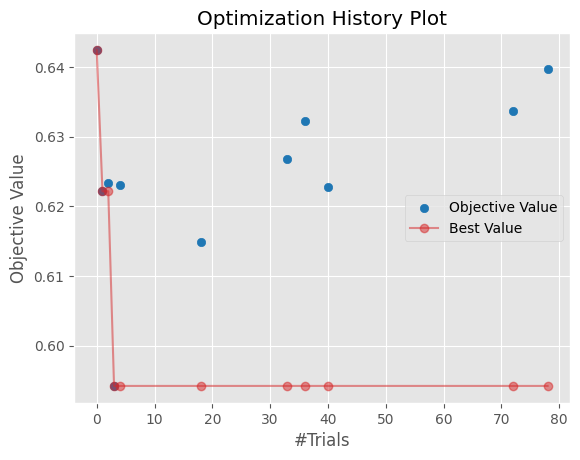

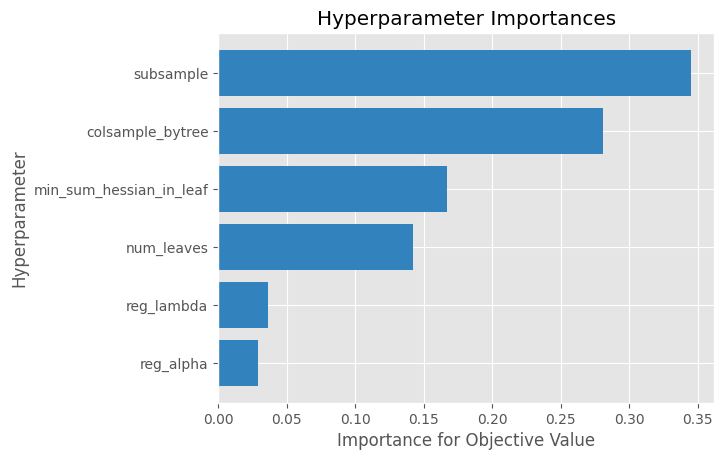

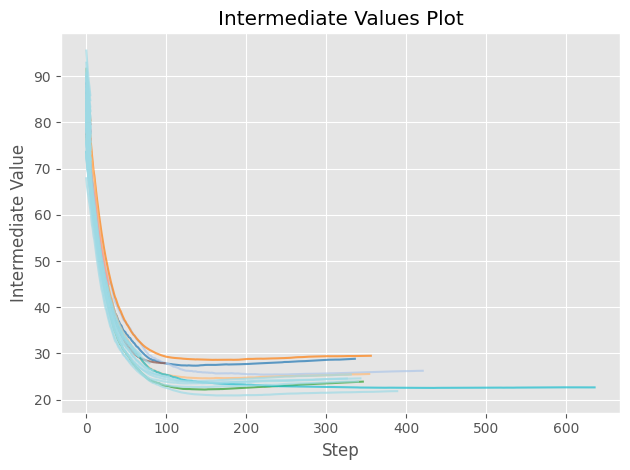

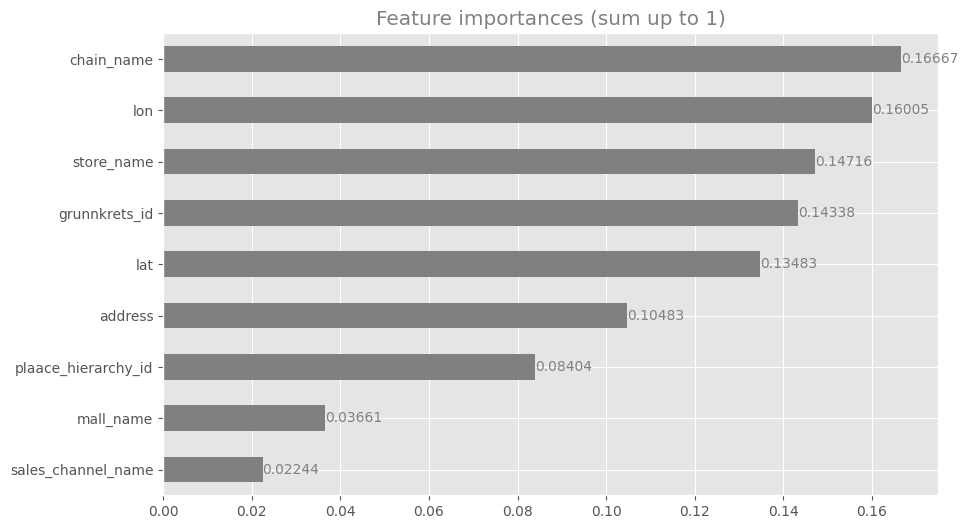



Time elapsed for fit execution: 27.6723 seconds


In [218]:

# Tune
tuner = LGBMTuner(metric = 'rmsle', verbosity=0)
tuner.fit(x_train, y_train)



### Lime

In [ ]:
#lime stuff in python

### Feature importance

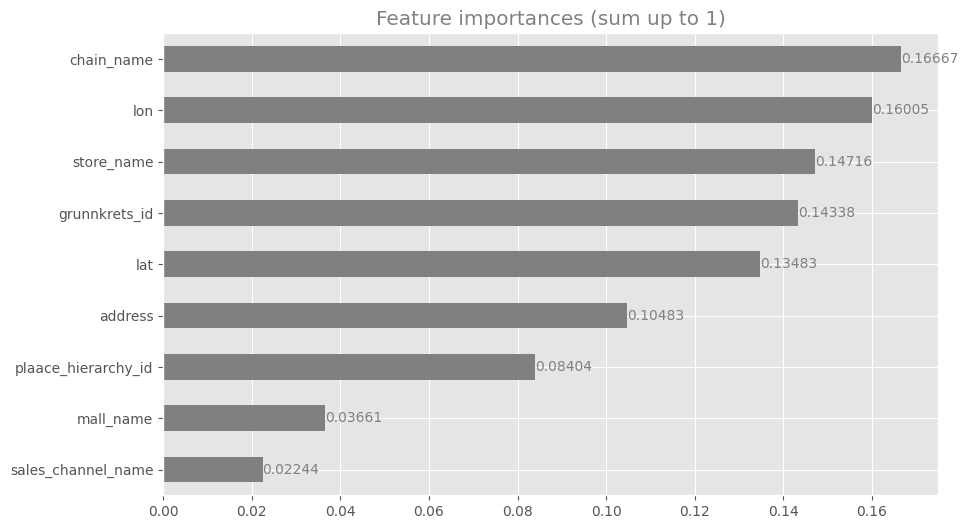

In [60]:
#feature importance

tuner.plot_importances()


### PDP

In [ ]:
#PDP

# 5. Final improved models/predictions

### model 1

In [ ]:
#final model 1

### model 2

In [ ]:
#final model 2

# Testing


#### RMSLE

In [ ]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5
